In [27]:
from swiper2.schedule_experiments import MemorySchedule, RegularTSchedule, MSD15To1Schedule
from swiper2.device_manager import DeviceManager
from swiper2.window_builder import WindowBuilder
from swiper2.window_manager import SlidingWindowManager
from swiper2.decoder_manager import DecoderManager
import swiper2.plot as plotter

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [28]:
def draw_dag(G):
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")

    nx.draw_networkx(G, pos=pos)

# Sliding Window Scheme

In [48]:
d=7
decoding_time = 2 * d
speculation_time = 0
speculation_accuracy = 0

## Memory Operation

In [49]:
memory_schedule = MemorySchedule(10 * d)
manager = DeviceManager(d, memory_schedule.schedule)
sliding_manager = SlidingWindowManager(WindowBuilder(d, enforce_alignment=False))
decoder_manager = DecoderManager(lambda _: decoding_time, speculation_time, speculation_accuracy)
instruction_idx_range = set(range(len(memory_schedule.schedule.all_instructions)))
while not manager.is_done():
    new_round = manager.get_next_round(instruction_idx_range - decoder_manager.decoded_instruction_idx())
    sliding_manager.process_round(new_round)
    decoder_manager.update_decoding(sliding_manager.all_windows, sliding_manager.window_dag)
    

<Axes3D: >

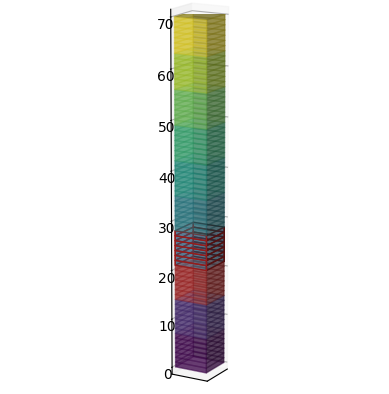

In [50]:
plotter.plot_device_schedule_trace(manager.get_data(), spacing=1, 
                                   windows=sliding_manager.all_windows, 
                                   window_schedule_times=range(len(sliding_manager.all_windows)),
                                   window_buffers_to_highlight=[2])

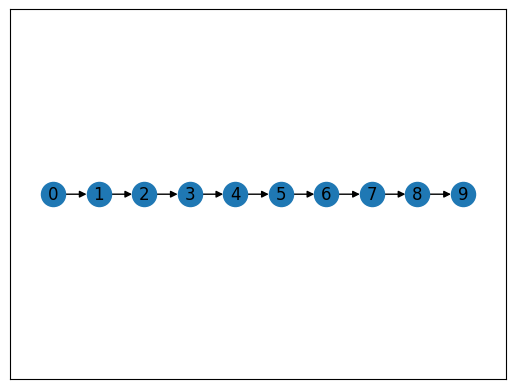

In [51]:
draw_dag(sliding_manager.window_dag)

## Regular T Schedule

<font color=red>TODO: debug, runtime should not vary with speculation time if speculation accuracy is 0</font>

In [52]:
d=7
memory_schedule = RegularTSchedule(5, 2)
manager = DeviceManager(d, memory_schedule.schedule)
sliding_manager = SlidingWindowManager(WindowBuilder(d, enforce_alignment=False))
decoder_manager = DecoderManager(lambda _: decoding_time, speculation_time, speculation_accuracy)
instruction_idx_range = set(range(len(memory_schedule.schedule.all_instructions)))
window_queue_history = []
windows_to_decode = 0

while not manager.is_done() or windows_to_decode > 0:
    new_round = manager.get_next_round(instruction_idx_range - decoder_manager.decoded_instruction_idx())
    sliding_manager.process_round(new_round)
    decoder_manager.update_decoding(sliding_manager.all_windows, sliding_manager.window_dag)
    windows_to_decode = len(sliding_manager.all_windows) - len(decoder_manager._window_completion_times)
    window_queue_history.append(windows_to_decode)

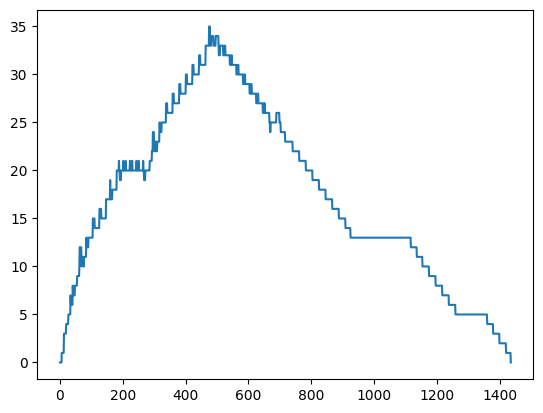

In [53]:
plt.plot(range(len(window_queue_history)), window_queue_history)
plt.show()

# Rounds: 1436


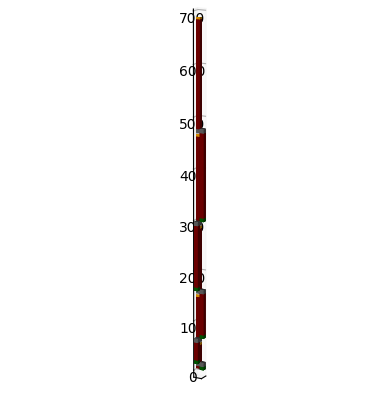

In [54]:
plotter.plot_device_schedule_trace(manager.get_data(), spacing=1)
print(f"# Rounds: {len(decoder_manager.get_data().max_parallel_processes_by_round)}")

<Axes3D: >

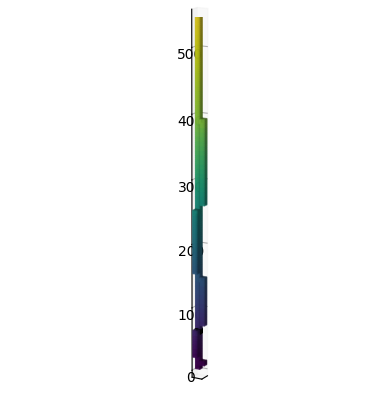

In [36]:
plotter.plot_device_schedule_trace(manager.get_data(), spacing=1,
                                   windows=sliding_manager.all_windows, 
                                   window_schedule_times=range(len(sliding_manager.all_windows)),
                                   window_buffers_to_highlight=[14],
                                   selected_window_colors=['k'])

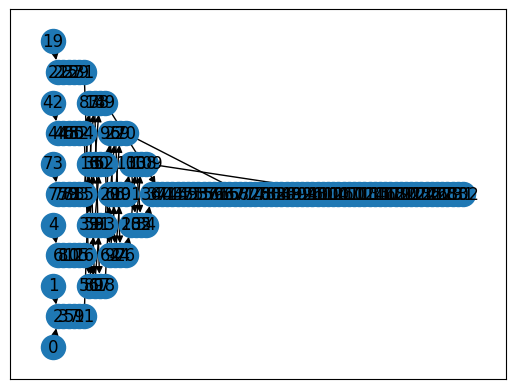

In [37]:
draw_dag(sliding_manager.window_dag)

## 15 - 1 Factory

<font color=red>VERIFY CORRECTNESS</font>

In [38]:
#%%capture
# Prevent flood of animation frames
d=7
msd_schedule = MSD15To1Schedule()
manager = DeviceManager(d, msd_schedule.schedule)
sliding_manager = SlidingWindowManager(WindowBuilder(d, enforce_alignment=False))
decoder_manager = DecoderManager(lambda _: decoding_time, speculation_time, speculation_accuracy)
instruction_idx_range = set(range(len(msd_schedule.schedule.all_instructions)))
frame_data = []
fig = plt.figure()
window_queue_history = []
windows_to_decode = 0
while not manager.is_done() or windows_to_decode > 0:
    new_round = manager.get_next_round(instruction_idx_range - decoder_manager.decoded_instruction_idx())
    sliding_manager.process_round(new_round)
    decoder_manager.update_decoding(sliding_manager.all_windows, sliding_manager.window_dag)
    windows_to_decode = len(sliding_manager.all_windows) - len(decoder_manager._window_completion_times)
    window_queue_history.append(windows_to_decode)
    # ax = plotter.plot_device_schedule_trace(manager.get_data(), spacing=1, default_fig=fig)
    # ax.set_zticks([])
    # frame_data.append(ax)

<Figure size 640x480 with 0 Axes>

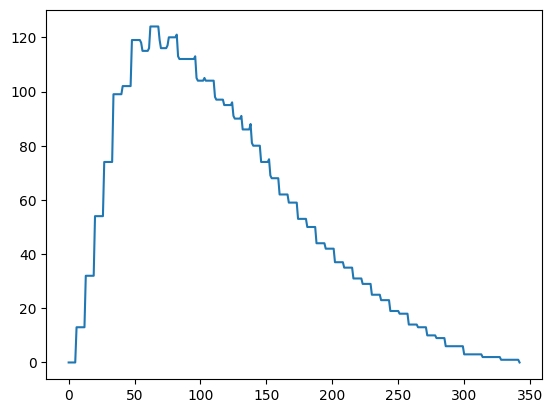

In [39]:
plt.plot(range(len(window_queue_history)), window_queue_history)
plt.show()

<Axes3D: >

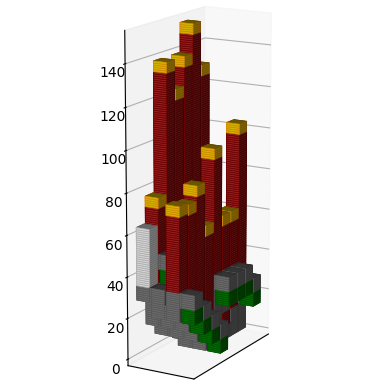

In [40]:
plotter.plot_device_schedule_trace(manager.get_data(), spacing=1)

In [41]:
# ani = animation.ArtistAnimation(fig=fig, artists=[[frame] for frame in frame_data], interval=400)
# ani.save('msd_schedule.mp4', writer='ffmpeg', fps=10)

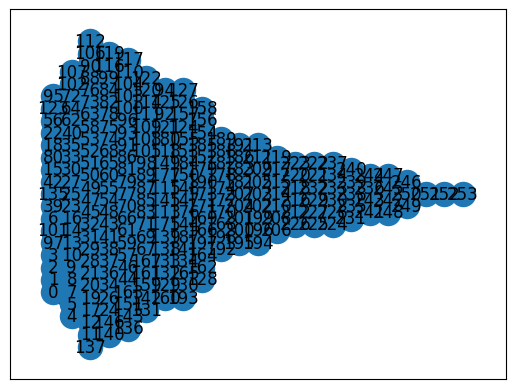

In [42]:
draw_dag(sliding_manager.window_dag)

<Axes3D: >

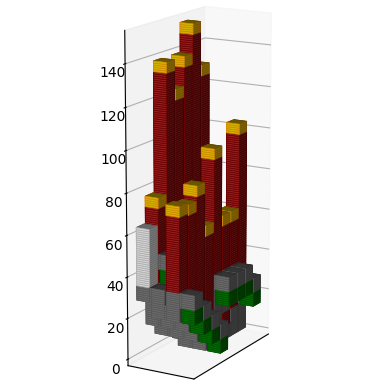

In [43]:
plotter.plot_device_schedule_trace(manager.get_data(), spacing=1)

<Axes3D: >

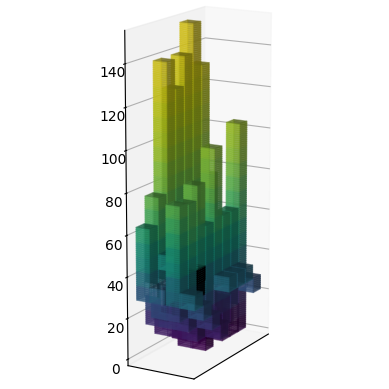

In [44]:
plotter.plot_device_schedule_trace(manager.get_data(), spacing=1,
                                   windows=sliding_manager.all_windows, 
                                   window_schedule_times=range(len(sliding_manager.all_windows)),
                                   window_buffers_to_highlight=[104],
                                   selected_window_colors=['k'])